In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from src.utils.custom_formatter import setup_custom_logger
logger = setup_custom_logger(__name__, level=logging.DEBUG)

- Load dataset to have actual returns and market returns

In [3]:
from src import Analyzer
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


ret, hor = an.build_returns()

ret = (np.exp(ret) -1)*100
ret

2025-05-07 14:04:45,115 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-07 14:04:51,970 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)


,rh_portfolio
date,
2018-05-03,-0.602745
2018-05-04,1.683162
2018-05-07,0.852330
2018-05-08,0.413330
2018-05-09,1.028846
...,...
2020-01-28,1.713913
2020-01-29,-0.579647
2020-01-30,-0.322621


In [4]:
import pandas as pd
from config.constants import PROJECT_ROOT

daily_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/18_rwarh_d_1.csv", index_col=0)
daily_factors.index = pd.to_datetime(daily_factors.index, format="%Y%m%d")
daily_factors[["pfioret100", "xmkt", "rf"]]



daily_factors = daily_factors.merge(ret["rh_portfolio"], left_index=True, right_index=True, how="inner")
daily_factors /= 100 

daily_factors["xr"] = daily_factors["rh_portfolio"] - daily_factors["rf"]
daily_factors += 1

daily_factors = daily_factors[["xr", "xmkt"]]
daily_factors


,xr,xmkt
2018-06-04,1.007919,1.0048
2018-06-05,1.007607,1.0016
2018-06-06,1.009507,1.0086
2018-06-07,0.995381,0.9986
2018-06-08,1.003415,1.0031
...,...,...
2020-01-28,1.017079,1.0102
2020-01-29,0.994144,0.9990
2020-01-30,0.996714,1.0034
2020-01-31,0.981644,0.9826


In [3]:
#monthly_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/20_rwarh_m_1.csv", index_col=0)
#monthly_factors["xr"] = monthly_factors["pfioret100"] - monthly_factors["rf"]
#monthly_factors = monthly_factors[["xr", "xmkt"]]
#monthly_factors.index = pd.to_datetime(monthly_factors.index, format="%Y%m")
monthly_returns = (daily_factors).resample("M").prod() - 1
monthly_returns += 1
monthly_returns



,xr,xmkt
2018-06-30,1.008236,0.994128
2018-07-31,0.995874,1.032174
2018-08-31,1.070942,1.041184
2018-09-30,1.006036,1.000871
2018-10-31,0.893139,0.923333
2018-11-30,0.999990,1.016996
2018-12-31,0.890604,0.904717
2019-01-31,1.131084,1.066421
2019-02-28,1.054940,1.033878
2019-03-31,1.008846,1.010808


In [19]:
import numpy as np
from scipy import stats

def mean_diff_ci(a, b):

    # Sample statistics
    mean_diff = np.mean(a) - np.mean(b)
    n1, n2 = len(a), len(b)
    var1, var2 = np.var(a, ddof=1), np.var(b, ddof=1)  # sample variances

    # Standard error of the difference
    se_diff = np.sqrt(var1/n1 + var2/n2)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df = (var1/n1 + var2/n2)**2 / ((var1**2)/(n1**2 * (n1-1)) + (var2**2)/(n2**2 * (n2-1)))

    # t-critical value for 95% CI
    alpha = 0.05
    t_crit = stats.t.ppf(1 - alpha/2, df)

    # Confidence interval
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff

    return mean_diff, ci_lower, ci_upper 
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Gamma: -9.3370


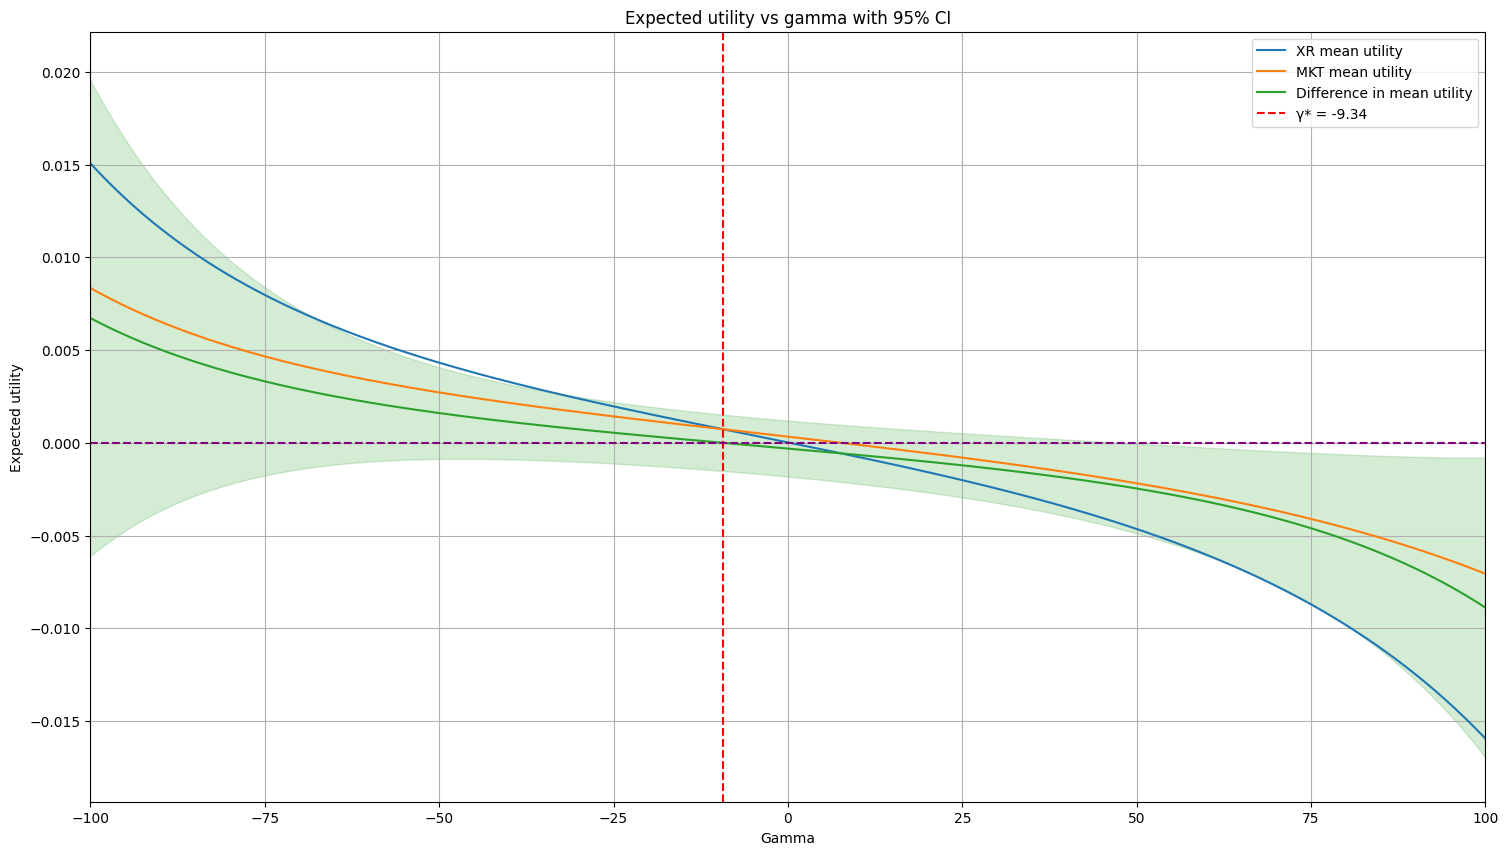

In [40]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility


df = daily_factors
parametric = False



import numpy as np
import matplotlib.pyplot as plt

# keep the scalar returned by the CE condition
gamma_hat = find_gamma_certainty_equivalent(df["xr"],
                                            df["xmkt"],
                                            parametric=parametric)

print(f"Gamma: {gamma_hat:.4f}")

hi = 100
lo = -hi
gap = 5
gammas = np.linspace(lo-1, hi+1, 1000)

utilities_xr  = []
utilities_xmkt = []
ut_diff = []

for g in gammas:
    #utilities_xr.append(compute_crra_utility(df["xr"], g, mean=True, confint=True))
    #utilities_xmkt.append(compute_crra_utility(df["xmkt"], g, mean=True, confint=True))
    ut_xr = compute_crra_utility(df["xr"], g, mean=False)
    ut_xmkt = compute_crra_utility(df["xmkt"], g, mean=False)

    ut_diff.append(mean_diff_ci(ut_xr, ut_xmkt))

    utilities_xr.append(np.mean(ut_xr))
    utilities_xmkt.append(np.mean(ut_xmkt))


means_diff, lo_diff, hi_diff = zip(*ut_diff)
#means_xr, lo_xr, hi_xr = zip(*utilities_xr)
#means_mk, lo_mk, hi_mk = zip(*utilities_xmkt)

means_xr = utilities_xr
means_mk = utilities_xmkt


plot=True

if plot:
    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    plt.plot(gammas, means_xr, label='XR mean utility', color='C0')
    #plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    plt.plot(gammas, means_mk, label='MKT mean utility', color='C1')
    #plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    plt.plot(gammas, means_diff, label='Difference in mean utility', color='C2')
    plt.fill_between(gammas, lo_diff, hi_diff, color='C2', alpha=0.2)

    plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    plt.axhline(0, color='purple', linestyle='--')
    plt.xlabel('Gamma')
    plt.xlim((lo,hi))
    plt.ylabel('Expected utility')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()




In [35]:
ut_diff

(np.float64(-0.0010554028553632798),
 np.float64(-0.0027263137616675764),
 np.float64(0.0006155080509410169))

Mean difference: -0.0003
95% CI: (-0.0018, 0.0012)


### All possible timeframes

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)



2025-05-02 12:41:07,298 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-02 12:41:13,687 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


In [45]:
all_ret_df = rt.build_all_pairs_dataframe()


100%|██████████| 144991/144991 [00:19<00:00, 7497.32it/s] 


Gamma: -5.43728


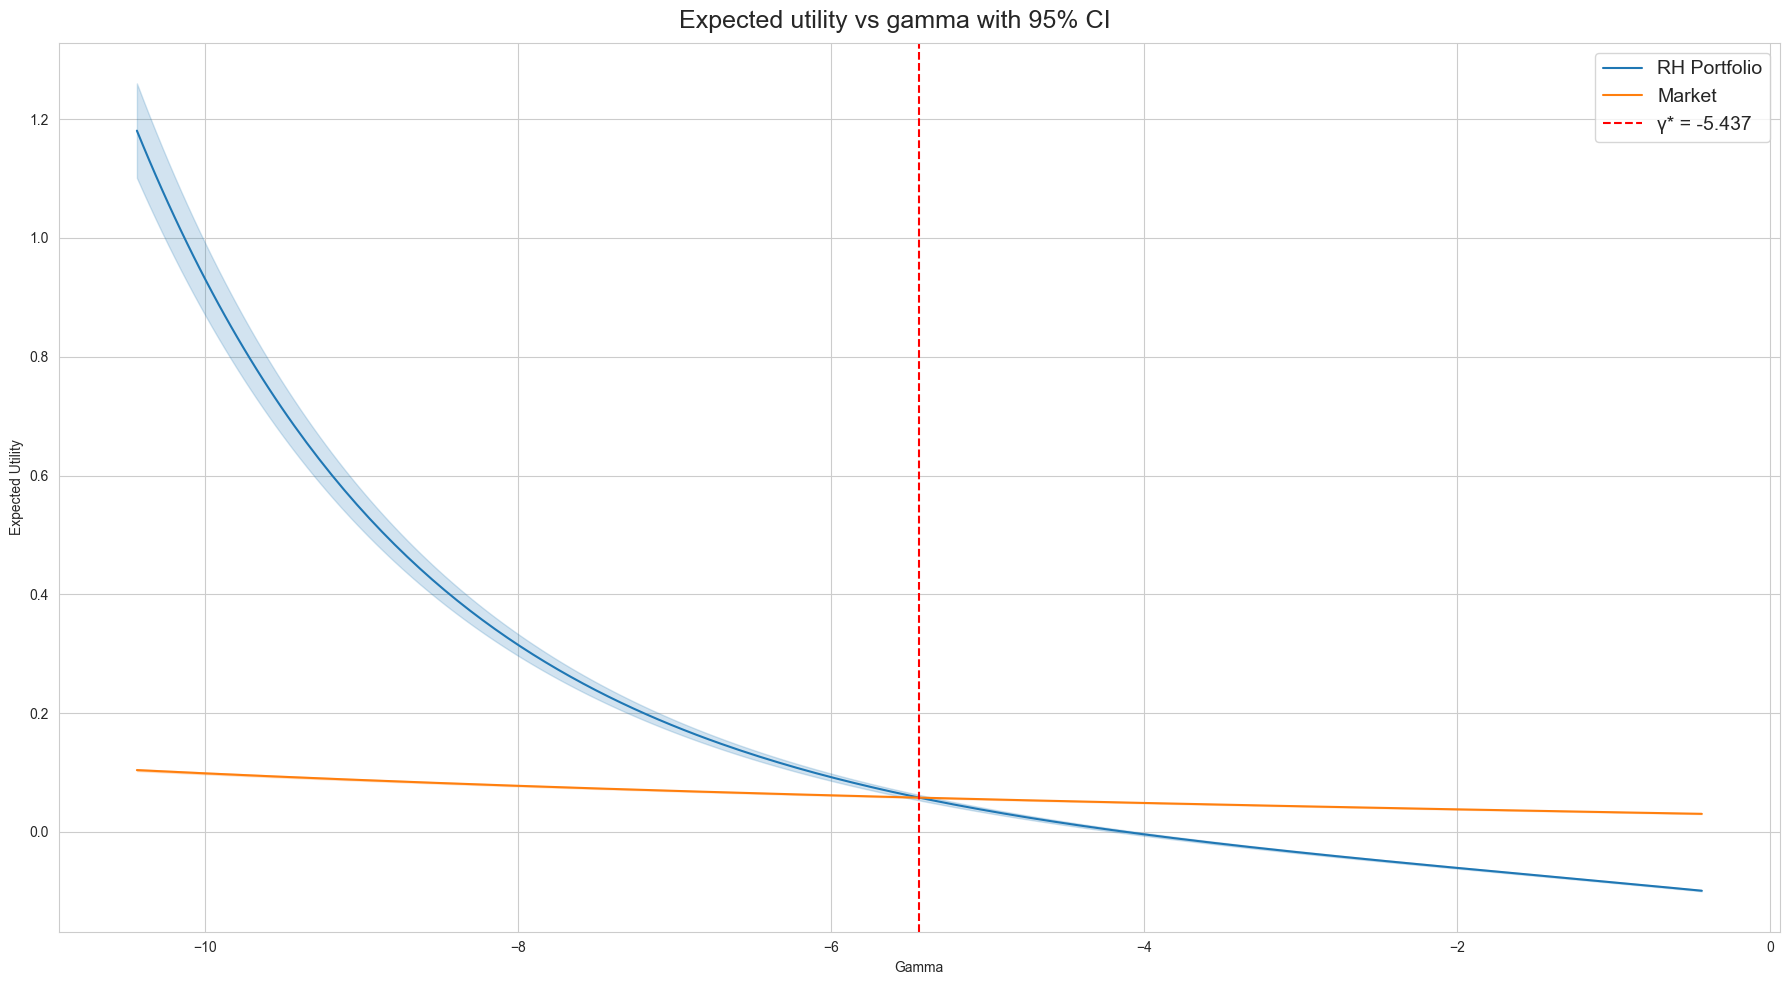

np.float64(-5.437281299436248)

In [46]:

rt.find_cutoff_gamma(df_returns=all_ret_df-1)

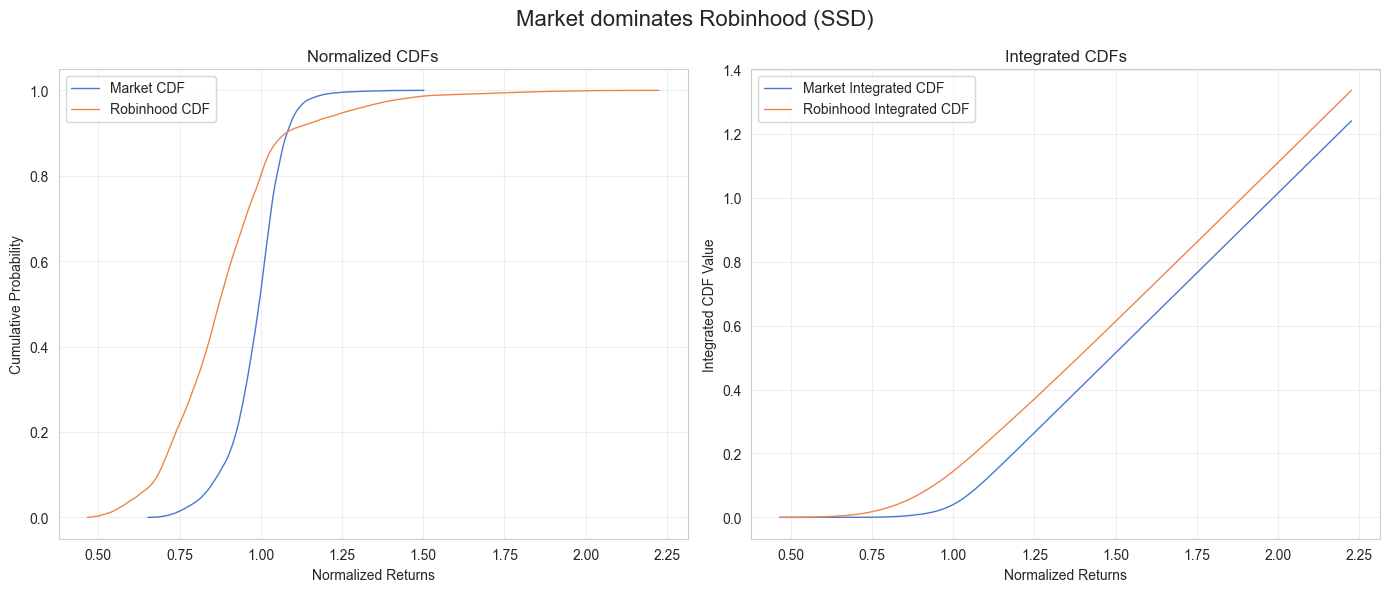

np.True_

In [33]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=all_ret_df, horizons=[1])])
plotter.plot_ssd_comparison(all_ret_df["xmkt"], all_ret_df["xr"], "Market", "Robinhood")

**Can't do bootstrapping as it assumes independent samples**

## Euler

In [2]:
%load_ext autoreload
%autoreload 2

In [53]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)
daily_factors = rt.factors
daily_factors.describe()

2025-05-02 12:52:16,464 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-02 12:52:18,424 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


,rh_portfolio,rf,mkt,xr,xmkt
count,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.000609,0.000066,0.000526,0.000544,0.000460
std,0.020192,0.000033,0.016152,0.020195,0.016153
min,-0.117828,0.000000,-0.119940,-0.117888,-0.120000
25%,-0.006983,0.000060,-0.004025,-0.007065,-0.004100
50%,0.000725,0.000070,0.001280,0.000635,0.001200
75%,0.008794,0.000090,0.006890,0.008704,0.006800
max,0.102957,0.000100,0.093460,0.102897,0.093400


In [54]:
monnthly_factors = rt.resample_factors()
monnthly_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-30,0.009446,0.001201,-0.004678,0.008236,-0.005872
2018-07-31,-0.002451,0.001681,0.033907,-0.004126,0.032174
2018-08-31,0.072512,0.001471,0.042713,0.070942,0.041184
2018-09-30,0.007566,0.001521,0.002393,0.006036,0.000871
2018-10-31,-0.105207,0.001842,-0.074961,-0.106861,-0.076667
2018-11-30,0.001672,0.001681,0.018705,-0.000010,0.016996
2018-12-31,-0.107692,0.001902,-0.093553,-0.109396,-0.095283
2019-01-31,0.132882,0.001601,0.068122,0.131084,0.066421
2019-02-28,0.056941,0.001902,0.035840,0.054940,0.033878
2019-03-31,0.010753,0.001892,0.012719,0.008846,0.010808


In [55]:
gamma_gmm = rt.estimate_euler_gamma(df_returns=daily_factors)
gamma_gmm

np.float64(3.0714922378400455)

Gamma: 1.12160


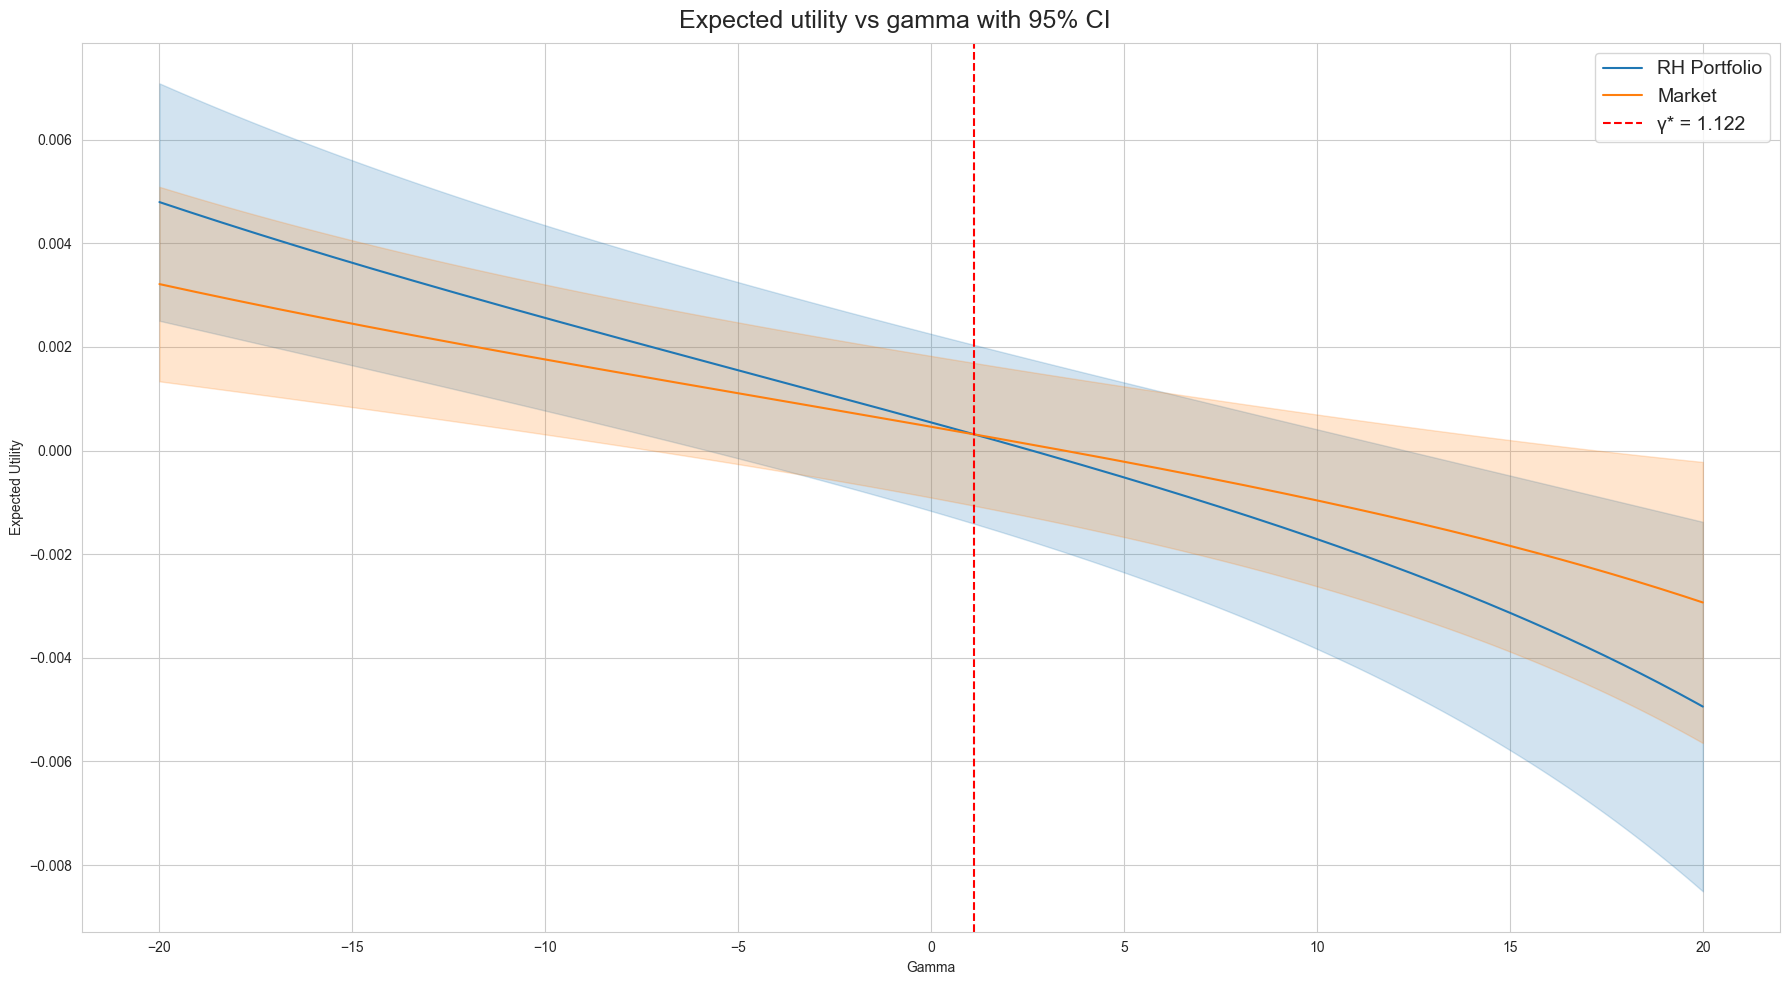

np.float64(1.1216008776527822)

In [58]:
rt.find_cutoff_gamma(bounds=(-20,20))

In [3]:
df = daily_factors +1
df

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,1.007979,1.00006,1.005061,1.007919,1.005001
2018-06-05,1.007667,1.00006,0.999735,1.007607,0.999675
2018-06-06,1.009567,1.00006,1.008749,1.009507,1.008689
2018-06-07,0.995441,1.00006,0.996583,0.995381,0.996523
2018-06-08,1.003475,1.00006,1.002242,1.003415,1.002182
...,...,...,...,...,...
2020-08-07,0.996141,1.00000,0.996542,0.996141,0.996542
2020-08-10,1.019014,1.00000,1.002726,1.019014,1.002726
2020-08-11,0.980078,1.00000,0.996910,0.980078,0.996910
2020-08-12,1.006672,1.00000,1.015001,1.006672,1.015001


In [14]:
rt.bootstrap_difference_utility(df_returns=df, gamma0=gamma_gmm)

ΔU (xmkt - rh_portfolio) at γ=3.071: -0.00017 [-0.00097, 0.00061]


(np.float64(-0.00017284581852384324),
 np.float64(-0.0009742359888587294),
 np.float64(0.0006114926814635308))

In [39]:
daily_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,0.007979,0.00006,0.005061,0.007919,0.005001
2018-06-05,0.007667,0.00006,-0.000265,0.007607,-0.000325
2018-06-06,0.009567,0.00006,0.008749,0.009507,0.008689
2018-06-07,-0.004559,0.00006,-0.003417,-0.004619,-0.003477
2018-06-08,0.003475,0.00006,0.002242,0.003415,0.002182
...,...,...,...,...,...
2020-08-07,-0.003859,0.00000,-0.003458,-0.003859,-0.003458
2020-08-10,0.019014,0.00000,0.002726,0.019014,0.002726
2020-08-11,-0.019922,0.00000,-0.003090,-0.019922,-0.003090
2020-08-12,0.006672,0.00000,0.015001,0.006672,0.015001


In [114]:
rt.bootstrap_gamma(daily_factors)

γ̂^GMM = 3.0715
95% BCa CI = [0.9072, 19.8172]


{'gamma_estimate': np.float64(3.0714922378400455),
 'ci_lower': np.float64(0.9072428346440041),
 'ci_upper': np.float64(19.817195964133305),
 'confidence_level': 0.95,
 'n_resamples': 5000}

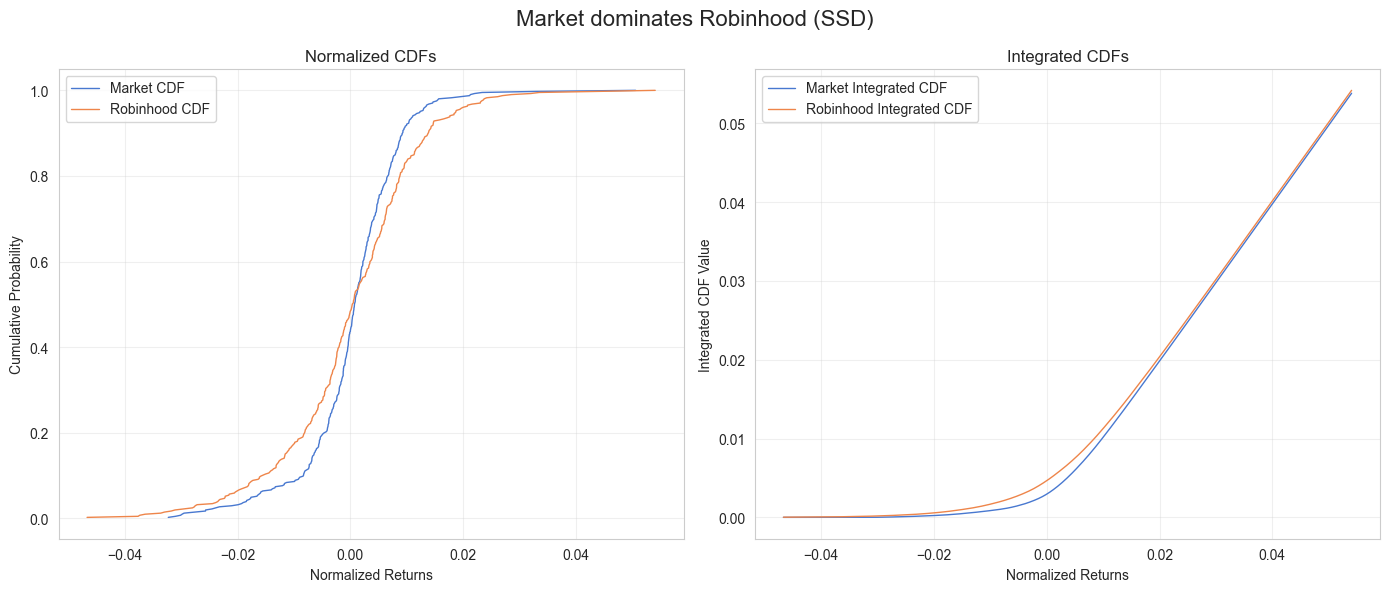

np.True_

In [45]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=daily_factors, horizons=[])])
plotter.plot_ssd_comparison(daily_factors["mkt"], daily_factors["rh_portfolio"], "Market", "Robinhood")

## Factors tests

In [66]:
import pandas as pd
from src.utils.helpers import load_factors
df_replication = load_factors()
df_download = pd.read_csv("../data/models/F-F_Research_Data_5_Factors_2x3_daily.csv", skiprows=2, index_col=0)


In [59]:
df_replication["mkt"] = df_replication["xmkt"] + df_replication["rf"]
df_replication

,pfioret100,xmkt,smb,hml,rmw,cma,rf,umd,mkt
yyyymmdd,,,,,,,,,
20180604,0.801442,0.48,0.15,-0.46,1.06,-0.30,0.006,0.17,0.486
20180605,0.838875,0.16,0.79,-0.43,0.23,0.11,0.006,0.29,0.166
20180606,0.909019,0.86,-0.28,0.19,-0.02,0.15,0.006,-0.01,0.866
20180607,-0.440410,-0.14,-0.24,0.91,0.17,0.59,0.006,-0.91,-0.134
20180608,0.341546,0.31,0.05,-0.41,0.27,-0.19,0.006,-0.13,0.316
...,...,...,...,...,...,...,...,...,...
20200810,1.828497,0.24,1.27,1.66,0.86,1.24,0.000,-2.82,0.240
20200811,-2.154837,-0.83,0.18,1.57,0.89,0.07,0.000,-2.21,-0.830
20200812,0.948135,1.40,-0.81,-1.30,0.95,-0.14,0.000,1.87,1.400


In [71]:
df_download = df_download.rename(columns={"Mkt-RF":"xmkt"}) 
df_download.columns = [f"{col.lower()}" for col in df_download.columns]
df_download["mkt"] = df_download["xmkt"] + df_download["rf"]
df_download.index = pd.to_datetime(df_download.index, format="%Y%m%d") 
df_download /=100
df_download

,xmkt,smb,hml,rmw,cma,rf,mkt
1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013,0.00012,-0.00658
1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021,0.00012,0.00802
1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025,0.00012,0.00642
1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030,0.00012,0.00412
1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006,0.00012,-0.00618
...,...,...,...,...,...,...,...
2024-12-24,0.0111,-0.0012,-0.0005,-0.0013,-0.0037,0.00017,0.01127
2024-12-26,0.0002,0.0109,-0.0019,-0.0044,0.0035,0.00017,0.00037
2024-12-27,-0.0117,-0.0044,0.0056,0.0041,0.0003,0.00017,-0.01153
2024-12-30,-0.0109,0.0024,0.0074,0.0055,0.0014,0.00017,-0.01073


In [72]:
df_download.to_parquet("../data/ff_market.parquet")

In [48]:

#df_mergeed = df_replication.merge(df_download, right_index=True, left_index=True)
#df_mergeed